In [31]:
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
import math
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import re
import time
from selenium import webdriver
from itertools import chain

圖片裁切

In [3]:

def resize_image(inputfo,outputfo):
    if not os.path.exists(outputfo):
        os.makedirs(outputfo)

    files = os.listdir(inputfo)
    target_size = (224, 224)

    for file_name in files:
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(inputfo, file_name)
            image = cv2.imread(image_path)
        
            if image is not None:
                h, w = image.shape[:2]
                if w > h:
                    new_w = target_size[0]
                    new_h = int(h * (new_w / w))
                else:
                    new_h = target_size[1]
                    new_w = int(w * (new_h / h))

                resize_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
                cropped_image = cv2.resize(resize_img, target_size, interpolation=cv2.INTER_AREA)

                output_path = os.path.join(outputfo, file_name)
                cv2.imwrite(output_path, cropped_image)
                print(f'{file_name} ')
            else:
                print(f"{file_name} 失敗")

增加圖片(daisy,sunflower,balloonflower,poinsettia) 導入

In [59]:
files = (r'D:\USERDATA\Desktop\test1\tree poppy')
newpic = os.listdir(files)

for name in newpic:
    image_path = files + '/' + name
    Centroid(image_path)
    Radius(image_path)
    Cut(image_path)
    
    

In [24]:
HSV=[114, 134, 181]
HSV=np.array(HSV)
def HSV_differentiate(HSV):
    h=HSV[0]*2
    s=HSV[1]*100/255
    v=HSV[2]*100/255
    if  v<20:
        l=0
    elif s<20 and 20<=v<80 :
        l=math.floor(((v/100-0.2)*10))+1   
    elif s<20 and 80<=v<=100:
        l=7
    else:
        if h>22 and h<=45:
            H=1
        elif h>45 and h<=70:
            H=2
        elif h>70 and h<=155:
            H=3
        elif h>155 and h<=186:
            H=4
        elif h>186 and h<=278:
            H=5
        elif h>278 and h<=330:
            H=6
        else:H=0
        if s>20 and s<=65:
            S=0
        else:S=1
        if v>20 and v<=70:
            V=0
        else:V=1
        l=4*H+2*S+V+8
    return l

In [5]:
#畫出圓形區域
def Centroid(img):
    img = cv2.imread(img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,0)
    M = cv2.moments(thresh)
    #質心
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    if cX>cY:
        radius=cY-1
    else:radius=cX-1
        
    cv2.circle(img, (cX, cY), 2, (255, 255, 255), -1)
    cv2.circle(img, (cX, cY), radius,(255, 255, 255), 0)
    cv2.circle(img, (cX, cY), radius//3,(255, 255, 255), 0)
    cv2.circle(img, (cX, cY), radius*2//3,(255, 255, 255), 0)
 

    return ((cX,cY))


In [6]:
##質心半徑
def Radius(img):
    img = cv2.imread(img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,0)
    M = cv2.moments(thresh)
    #質心
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    if cX>cY:
        radius=cY-1
    else:radius=cX-1
    
    return radius

In [17]:
#切割圓形區域


def Cut(img):
    name=img.split("/")
    
    img_=cv2.imread(img)
    img1=cv2.imread((img))
    img2=cv2.imread((img))
    img3=cv2.imread((img))
    #質心半徑
    r=Radius(img)
    ##遮蓋罩##
    ##最大
    #MASK1=np.zeros_like(img1)
    MASK1=np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK1, (111,124), r, (255, 255, 255), -1) 
    ##次之
    #MASK2=np.zeros_like(img2)
    MASK2=np.zeros((img2.shape[0], img2.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK2, (111,124), r*2//3, (255, 255, 255), -1)

    ##最小 
    #MASK3=np.zeros_like(img3)
    MASK3=np.zeros((img3.shape[0], img3.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK3, (111,124), r//3, (255, 255, 255), -1)
    mask2 = cv2.subtract(MASK2, MASK3)
    mask1 = cv2.subtract(MASK1, MASK2)
    
    imgAddMask1 = cv2.add(img1, np.zeros(np.shape(img1), dtype=np.uint8), mask=mask1)
    imgAddMask2 = cv2.add(img2, np.zeros(np.shape(img2), dtype=np.uint8), mask=mask2)
    imgAddMask3 = cv2.add(img3, np.zeros(np.shape(img3), dtype=np.uint8), mask=MASK3)
    cv2.imwrite("cuta/cut1_"+name[-2]+"_"+name[-1], imgAddMask1)
    cv2.imwrite("cuta/cut2_"+name[-2]+"_"+name[-1], imgAddMask2)
    cv2.imwrite("cuta/cut3_"+name[-2]+"_"+name[-1], imgAddMask3)

In [22]:
#色彩直方圖
def Color_hist(cut1,cut2,cut3):
    img1 = cv2.imread(cut1)
    img2 = cv2.imread(cut2)
    img3 = cv2.imread(cut3)
    
    img1_=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
    img2_=cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
    img3_=cv2.cvtColor(img3,cv2.COLOR_BGR2HSV)
    
    ##刪除純黑## 
    black=np.array([0,0,0])
    color_list_1_no_black=[]
    color_list_2_no_black=[]
    color_list_3_no_black=[]
    
    for i in img1_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_1_no_black.append(k)
                #print(k)
    for i in img2_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_2_no_black.append(k)
                #print(k)
    for i in img3_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_3_no_black.append(k)
                #print(k)    

    color_hist_1=[]
    for i in color_list_1_no_black:
        color_hist_1.append(HSV_differentiate(i))
    #plt.subplot(131) 
    #plt.hist(color_hist_1)

    color_hist_2=[]
    for i in color_list_2_no_black:
        color_hist_2.append(HSV_differentiate(i))
    #plt.subplot(132) 
    #plt.hist(color_hist_2)


    color_hist_3=[]
    for i in color_list_3_no_black:
        color_hist_3.append(HSV_differentiate(i))
    #plt.subplot(133) 
    #plt.hist(color_hist_3)
    for i in color_hist_1:
        if i==0:
            color_hist_1.remove(i)
        else: continue
    for i in color_hist_2:
        if i==0:
            color_hist_2.remove(i)
        else: continue
    for i in color_hist_3:
        if i==0:
            color_hist_3.remove(i)
        else: continue
    all_hist=[]
    all_hist=color_hist_1
    for i in color_hist_2:
        all_hist.append(i+35)
    for i in color_hist_3:
        all_hist.append(i+70)
    
    
    
    return all_hist

In [62]:
all_hist_1=Color_hist('cuts/cut1_iris_12769.jpeg','cuts/cut2_iris_12769.jpeg','cuts/cut3_iris_12769.jpeg')   
all_hist_2=Color_hist('cuts/cut1_iris_16301.jpeg','cuts/cut2_iris_16301.jpeg','cuts/cut3_iris_16301.jpeg')  

In [36]:
title={
    "id":[],
    'name_En':[],
    #'name_Ch':[],
    'color_hist':[],

    
}
def GetId(img):
    name=img.split("/")
    ID=name[-1][:-5]
    return ID

def GetName(img):
    name=img.split("/")
    Name=name[-2]
    return Name
flower_db2=pd.DataFrame(title)
flower_db2

,id,name_En,color_hist


finish


{'id': '100',
 'name_En': 'daisy',
 'color_hist': array([1.280e+02, 1.570e+02, 1.830e+02, 2.980e+02, 6.090e+02, 2.173e+03,
        6.901e+03, 3.900e+01, 2.000e+00, 1.600e+01, 1.000e+00, 9.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 3.700e+01, 2.000e+00, 1.500e+01,
        0.000e+00, 1.385e+03, 1.600e+01, 1.660e+03, 4.600e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.000e+00, 1.000e+00, 1.000e+00, 1.522e+03, 9.700e+01,
        1.230e+02, 1.370e+02, 2.370e+02, 3.850e+02, 1.148e+03, 8.147e+03,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 4.000e+00,
        1.100e+01, 3.100e+01, 6.700e+01, 1.860e+02, 5.200e+01, 4.430e+02,
        3.800e+01, 2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 9.620e+02, 1.300e+01, 1.400e+01,
        1.900e+01, 2.600e+01, 3.100e+01, 8.200e+01, 5.330e+02, 

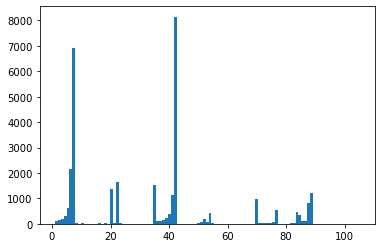

In [37]:
def To_Data(img):
    name=img.split("/")
    Cut(img)
    H=Color_hist("cuta/cut1_"+name[-2]+"_"+name[-1],"cuta/cut2_"+name[-2]+"_"+name[-1],"cuta/cut3_"+name[-2]+"_"+name[-1])
    
    
    # H1=plt.hist(H1,35,(1,36))
    # H2=plt.hist(H2,35,(1,36))
    # H3=plt.hist(H3,35,(1,36))
    HIST=plt.hist(H,105,(1,105))
    # data={
    # "id":GetId(img),
    # 'name_En':GetName(img),
    # 'color_hist_1':H1[0],
    # 'color_hist_2':H2[0],
    # 'color_hist_3':H3[0]
    # }
    data={
    "id":GetId(img),
    'name_En':GetName(img),
    #'name_Ch':[],
    'color_hist':HIST[0],

    
}

   
    
    #H2_remake=[]
    #H3_remake=[]
    #for i in H2:
        #H2_remake.append(i+"2")
    #for i in H3:
        #H3_remake.append(i+"2")
    #H=H1+H2_remake+H3_remake    
    print("finish")
    
    return data
To_Data(r'D:/USERDATA/Desktop/test1/daisy/1000.jpg')

finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish

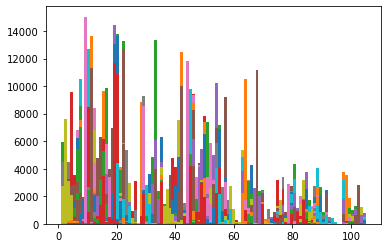

In [40]:
pathlist = chain(Path(r'D:\USERDATA\Desktop\test1').glob("**/*.jpeg"), Path(r'D:\USERDATA\Desktop\test1').glob("**/*.jpg"))
myfile = "filename.txt"
for path in pathlist:
    Path_=(str(path).replace('\\','/'))
    flower_db2=flower_db2.append(To_Data(Path_),ignore_index=True)

In [42]:
flower_db2.to_csv("flower_db2.csv")

In [66]:
def Compare_Hist(h1,h2):
    #H1=plt.hist(h1,36,(0,36))
    #H2=plt.hist(h2,36,(0,36))

    #H1_array=h1[0]
    H1_array=h1[:,np.newaxis]
    #H2_array=h2[0]
    H2_array=h2[:,np.newaxis]
    H1_array=np.float32(H1_array)
    H2_array=np.float32(H2_array)
    corr=(cv2.compareHist(H1_array,H2_array , method=0))#HISTCMP_CORREL
    dis=(cv2.compareHist(H1_array,H2_array , method=cv2.HISTCMP_BHATTACHARYYA))#巴氏距離
    
    return corr ,dis
def ChangeType(x):
    x=x.replace('\n','')
    x=x.replace('[','')
    x=x.replace(']','')
    x=x.split(' ')
    x=np.array(x)
    x=x.astype(np.float64)
    return x
df=pd.read_csv("flower_db2.csv")

def CompareData(test_img):
        name=test_img.split("/")
        Cut(test_img)
        H=Color_hist("cuts/cut1_"+name[-2]+"_"+name[-1],
                        "cuts/cut2_"+name[-2]+"_"+name[-1],
                        "cuts/cut3_"+name[-2]+"_"+name[-1])
        
        HIST=plt.hist(H,105,(1,105))
        # H1=plt.hist(H1,35,(1,36))
        # H2=plt.hist(H2,35,(1,36))
        # H3=plt.hist(H3,35,(1,36))
        # title={
        # "num":[],

        # 'color_hist_1_corr':[],
        # 'color_hist_2_corr':[],
        # 'color_hist_3_corr':[],
        # 'color_hist_1_dis':[],
        # 'color_hist_2_dis':[],
        # 'color_hist_3_dis':[],
        # }
        title={
        "num":[],
        'color_hist_corr':[],
        'color_hist_dis':[]
     }
        compare_db=pd.DataFrame(title)
        for i in range(0,len(df)):
                try:
                        num=i
                        train=df["color_hist"][i]
                        train=ChangeType(train)
                        test=HIST[0]
                        
                        corr,dis=Compare_Hist(train,test)
                        
                        data={
                        "num":str(num),
                        'color_hist_corr':corr,
                        'color_hist_dis':dis}
                      
                        # train_1=df["color_hist_1"][i]
                        # train_1=ChangeType(train_1)
                        # test_1=H1[0]
                        # #test_1=ChangeType(test_1)
                        # #print(train_1)
                        # train_2=df["color_hist_2"][i]
                        # train_2=ChangeType(train_2)
                        # test_2=H2[0]
                        # #test_2=ChangeType(test_2)
                        
                        # train_3=df["color_hist_3"][i]
                        # train_3=ChangeType(train_3)
                        # test_3=H3[0]
                        # #test_3=ChangeType(test_3)
                                
                        # corr1,dis1=Compare_Hist(train_1,test_1)
                        
                        # corr2,dis2=Compare_Hist(train_2,test_2)
                        # corr3,dis3=Compare_Hist(train_3,test_3)
                        # data={
                        # "num":str(num),
                        # 'color_hist_1_corr':corr1,
                        # 'color_hist_2_corr':corr2,
                        # 'color_hist_3_corr':corr3,
                        # 'color_hist_1_dis':dis1,
                        # 'color_hist_2_dis':dis2,
                        # 'color_hist_3_dis':dis3,
                        #                         }
                        
                        compare_db=compare_db.append(data,ignore_index=True)      
                except:pass
        return compare_db
def MostFlower(img):
    
    compare_db=CompareData(img)
    get_num=compare_db.nsmallest(3,"color_hist_dis",keep='all')
    get_num['num']
    flower_list=[]
    for i in get_num['num']:
        flower_list.append(df['name_En'][int(i)])
    
    maxlabel = max(flower_list,key=flower_list.count)
    max_corr=compare_db["color_hist_corr"].nlargest(3).index
    corr=[]
    for i in max_corr:
        corr.append(df['name_En'][i])
    maxlabel_corr = max(corr,key=corr.count)
    return maxlabel ,flower_list,corr,maxlabel_corr
def Test(img):
    maxlabel ,flower_list,corr,maxlabel_corr=MostFlower(img)
    flower_list.extend(corr)
    maxF = max(flower_list,key=flower_list.count)
    
    return maxF


In [67]:
def GetTestName(img):
    img=img
    Split=img.split("/")
    name=Split[1][:-7]
    return name

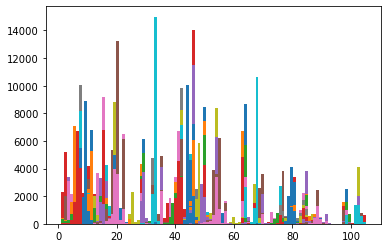

In [69]:
pathlist = chain(Path("testdata").glob("**/*.jpeg"), Path("testdata").glob("**/*.jpg"))
flower_correct_name=[]
flower_test_name=[]
for path in pathlist:
    Path_=(str(path).replace('\\','/'))
    name=GetTestName(Path_)
    test=Test(Path_)
    flower_correct_name.append(name)
    flower_test_name.append(test)


In [70]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(flower_correct_name, flower_test_name)

print("準確度:", accuracy)

準確度: 0.7894736842105263


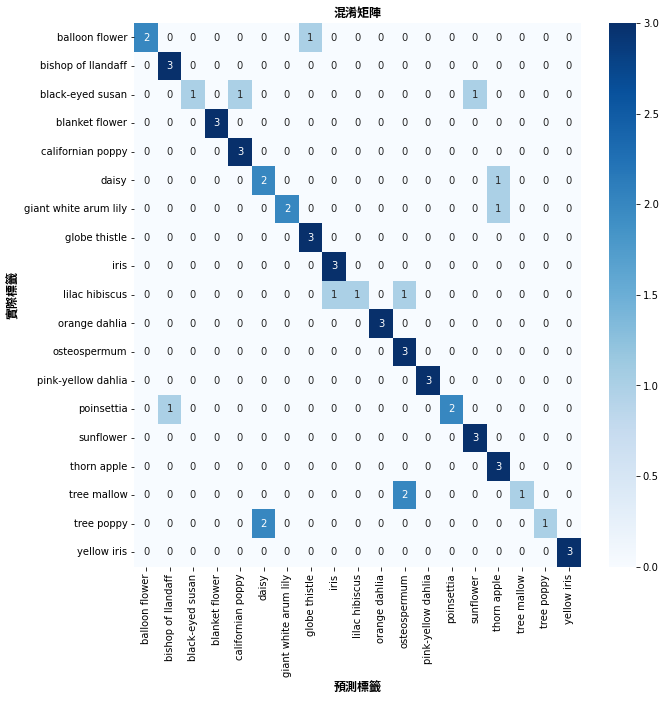

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from matplotlib.font_manager import FontProperties

from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(flower_correct_name, flower_test_name,labels=['balloon flower',
 'bishop of llandaff',
 'black-eyed susan',
 'blanket flower',
 'californian poppy',
 'daisy',
 'giant white arum lily',
 'globe thistle',
 'iris',
 'lilac hibiscus',
 'orange dahlia',
 'osteospermum',
 'pink-yellow dahlia',
 'poinsettia',
 'sunflower',
 'thorn apple',
 'tree mallow',
 'tree poppy',
 'yellow iris',
])
name=['balloon flower',
 'bishop of llandaff',
 'black-eyed susan',
 'blanket flower',
 'californian poppy',
 'daisy',
 'giant white arum lily',
 'globe thistle',
 'iris',
 'lilac hibiscus',
 'orange dahlia',
 'osteospermum',
 'pink-yellow dahlia',
 'poinsettia',
 'sunflower',
 'thorn apple',
 'tree mallow',
 'tree poppy',
 'yellow iris',
]
font = FontProperties(fname="NotoSansTC-Bold.ttf", size=12)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=name, yticklabels=name)
plt.xticks(rotation=90)
plt.title("混淆矩陣",font=font)
plt.xlabel("預測標籤",font=font)
plt.ylabel("實際標籤",font=font)
plt.show()